In [6]:
import sys

import matplotlib.pyplot as plt
import numpy as np

import torch
import os

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import src

In [8]:
def compute_accel(points):
    velocities = points[1:] - points[:-1]
    acceleration = velocities[1:] - velocities[:-1]
    return acceleration


def norm_accel(acceleration):
    acceleration_normed = torch.linalg.norm(acceleration, dim=2)
    return acceleration_normed  # B x N


def accel_err(accel_pred, accel_gt):
    """
    accel_pred, accel_gt - B x N x 3
    """
    err_normed = norm_accel(accel_pred - accel_gt)  # B x N
    return err_normed.mean(dim=1)  # B


m2mm = 1000

from src.losses.pose_eval import PAMPJPE

pa_mpjpe_vs_gt = PAMPJPE()

In [9]:
from src.models.spin import hmr
from src.models.tcmr import BASE_DIR, SPIN_FILE, TCMR, TCMR_TABLE4_FILE

from src.models.seq_optim import get_smpl_out, SeqModel
from src.functional import smpl

In [10]:
device = "cuda:2"
torch.set_grad_enabled(False)

### init feature extractor
hmr = hmr().to(device)
pretrained = os.path.join(BASE_DIR, SPIN_FILE)
pretrained_dict = torch.load(pretrained, map_location=device)["model"]
hmr.load_state_dict(pretrained_dict, strict=False)
hmr.eval();

In [11]:
seq = "downtown_runForBus_01_0"
f_name = f"sample_3dpw_test_seq_{seq}__hmr_coco_all.pth"

seq = torch.load(f"../dump_from_tcmr/{f_name}")

for k in seq:
    seq[k] = seq[k][:339]

image_batch = seq["img"]

In [12]:
j_regr = "../data/smpl_data/J_regressor_h36m.npy"
J_regressor = torch.from_numpy(np.load(j_regr)).float()

### first - obtain features of pretrained SPIN HMR

hmr = hmr.to(device)
features = []
for image_batch_ in image_batch.split(16):
    image_batch_ = image_batch_.to(device)
    feature = hmr.feature_extractor(image_batch_)
    features.append(feature.cpu())
features = torch.cat(features, dim=0)

# del image_batch_, hmr
# torch.cuda.empty_cache()
print(features.shape)

torch.Size([339, 2048])


In [14]:
### run TCMR
seq_len = 16

print("seqlen: ", seq_len)
tcmr_model = TCMR(seqlen=seq_len, n_layers=2, hidden_size=1024).to(device)
pretrained = os.path.join(BASE_DIR, TCMR_TABLE4_FILE)
pretrained_dict = torch.load(pretrained)["gen_state_dict"]
tcmr_model.load_state_dict(pretrained_dict, strict=False)
tcmr_model.eval();

seqlen:  16
=> loaded pretrained regressor model from '/cvlabdata2/home/davydov/videoHMR_SSL/dump_from_tcmr/spin_model_checkpoint.pth.tar'


In [15]:
input_features = [] # in the end: len(features) x seqlen x F (2048)
for curr_idx in range(len(features)):
    start_idx = curr_idx - seq_len // 2
    end_idx = curr_idx + seq_len // 2
    if start_idx < 0 or end_idx > len(features):
        feature = features[None, curr_idx : curr_idx + 1]
        feature = feature.repeat(1,seq_len,1)
    else:
        feature = features[None, start_idx : end_idx]
    input_features.append(feature)

input_features = torch.cat(input_features, dim=0)

In [16]:
pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d = [], [], [], [], []
max_batch = 8
for input_feature in torch.split(input_features, max_batch):
    output = tcmr_model(input_feature.to(device), J_regressor=J_regressor, is_train=False)[0][-1]

    pred_cam.append(output["theta"][:, :3])
    pred_verts.append(output["verts"])
    pred_pose.append(output["theta"][:, 3:75])
    pred_betas.append(output["theta"][:, 75:])
    pred_joints3d.append(output["kp_3d"])

pred_cam = torch.cat(pred_cam, dim=0)
pred_verts = torch.cat(pred_verts, dim=0)
pred_pose = torch.cat(pred_pose, dim=0)
pred_betas = torch.cat(pred_betas, dim=0)
pred_joints3d = torch.cat(pred_joints3d, dim=0)

verts_pred_tcmr = pred_verts.cpu()
j3d_pred_tcmr = pred_joints3d.cpu()

print(verts_pred_tcmr.shape, j3d_pred_tcmr.shape)

torch.Size([339, 6890, 3]) torch.Size([339, 14, 3])


# load GT, INIT and other exps to compare

In [17]:
### gt
seqOpt = SeqModel(
    "./../dump_from_tcmr/sample_3dpw_test_seq_downtown_runForBus_01_0__hmr_coco_all.pth",
    339,
)
seqOpt = seqOpt.to(device)
theta = seqOpt.orig_seq["theta"].to(device)
gt_smpl_pose, gt_smpl_shape = theta[:, 3:75], theta[:, 75:]

smpl_model = smpl.get_smpl_model("h36m", device=device)
gt_out = smpl_model(
    betas=gt_smpl_shape,
    body_pose=gt_smpl_pose[:, 3:],
    global_orient=gt_smpl_pose[:, :3],
)
verts_gt = gt_out.vertices.cpu()
j3d_gt = gt_out.joints.cpu()

print(verts_gt.shape, j3d_gt.shape)

accel_verts_gt = compute_accel(verts_gt).cpu() * 1000
accel_j3d_gt = compute_accel(j3d_gt).cpu() * 1000

j2d_init, j3d_init, verts_init = seqOpt.forward_with_init(smpl_model)
verts_init = verts_init.cpu()
j3d_init = j3d_init.cpu()

print(verts_init.shape, j3d_init.shape)

accel_verts_init = compute_accel(verts_init).cpu() * 1000
accel_j3d_init = compute_accel(j3d_init).cpu() * 1000

accel_verts_gt = compute_accel(verts_gt.clone()) * m2mm
accel_j3d_gt = compute_accel(j3d_gt.clone()) * m2mm
d_accel_verts = {"gt":accel_verts_gt}
d_accel_j3d = {"gt":accel_j3d_gt}

d_accel_verts["init"] = accel_verts_init
d_accel_verts["gt"] = accel_verts_gt

d_accel_j3d["init"] = accel_j3d_init
d_accel_j3d["gt"] = accel_j3d_gt

d_verts = dict(gt=verts_gt, init=verts_init, tcmr=verts_pred_tcmr)
d_j3d = dict(gt=j3d_gt, init=j3d_init, tcmr=j3d_pred_tcmr)

accel_verts_tcmr = compute_accel(verts_pred_tcmr) * m2mm
accel_j3d_tcmr = compute_accel(j3d_pred_tcmr) * m2mm

d_accel_verts["tcmr"] = accel_verts_tcmr
d_accel_j3d["tcmr"] = accel_j3d_tcmr

print(accel_verts_init.shape, accel_verts_gt.shape, accel_verts_tcmr.shape)
print(accel_j3d_init.shape, accel_j3d_gt.shape, accel_j3d_gt.shape)

torch.Size([339, 6890, 3]) torch.Size([339, 14, 3])
torch.Size([339, 6890, 3]) torch.Size([339, 14, 3])
torch.Size([337, 6890, 3]) torch.Size([337, 6890, 3]) torch.Size([337, 6890, 3])
torch.Size([337, 14, 3]) torch.Size([337, 14, 3]) torch.Size([337, 14, 3])


In [13]:
ckpt_names = {
    "smoothing" : "seq_optim_grid_shape_pose/grid__shape_1_pose_1_f30/ckpt.pth",
    "flow2d" : "seq_optim_flow/seq_optim__coco-all__3dpw_test_seq_339__flow2d__shorter_epochs/ckpt.pth",
    "flow2d + smoothing": "seq_optim_flow__temp_smooth/seq_optim__coco-all__3dpw_test_seq_339__grid_flow2d_0.001_smooth_3/ckpt.pth",
}

for i, (name, full_name) in enumerate(ckpt_names.items()):
    ckpt_path = f"manifold://xr_body/tree/personal/andreydavydov/my_exps/{full_name}"
    ckpt = torch.load(pathmgr.get_local_path(f"{ckpt_path}"), map_location='cpu')['seqOpt_state_dict']

    ### pred
    pose = ckpt["pose"].to(device)
    shape = ckpt["shape"].to(device)
    camera = ckpt["camera"].to(device)
    _, j3d, verts = get_smpl_out(shape, pose, camera, smpl_model, pose2rot=True)

    j3d = j3d.cpu()
    verts = verts.cpu()

    d_j3d[name] = j3d
    d_verts[name] = verts

    accel_verts_pred = compute_accel(verts) * 1000
    accel_j3d_pred = compute_accel(j3d) * 1000
    d_accel_verts[name] = accel_verts_pred
    d_accel_j3d[name] = accel_j3d_pred

I1011 024303.150 manifold.py:1452] Caching manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_1_pose_1_f30/ckpt.pth ...
I1011 024303.502 manifold.py:1506] URL manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_1_pose_1_f30/ckpt.pth cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_1_pose_1_f30/ckpt.pth
I1011 024303.555 manifold.py:1452] Caching manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_flow/seq_optim__coco-all__3dpw_test_seq_339__flow2d__shorter_epochs/ckpt.pth ...
I1011 024305.523 manifold.py:1506] URL manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_flow/seq_optim__coco-all__3dpw_test_seq_339__flow2d__shorter_epochs/ckpt.pth cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/my_exps/seq_optim_flow/seq_optim__coco-all__3dpw_test_seq_339__flow2d__short

In [14]:
colors = {"gt": "black", "init": "pink", "tcmr":"green"}
other_colors = ["blue", "darkorange", 'red']
for name, c in zip(ckpt_names, other_colors):
    colors[name] = c

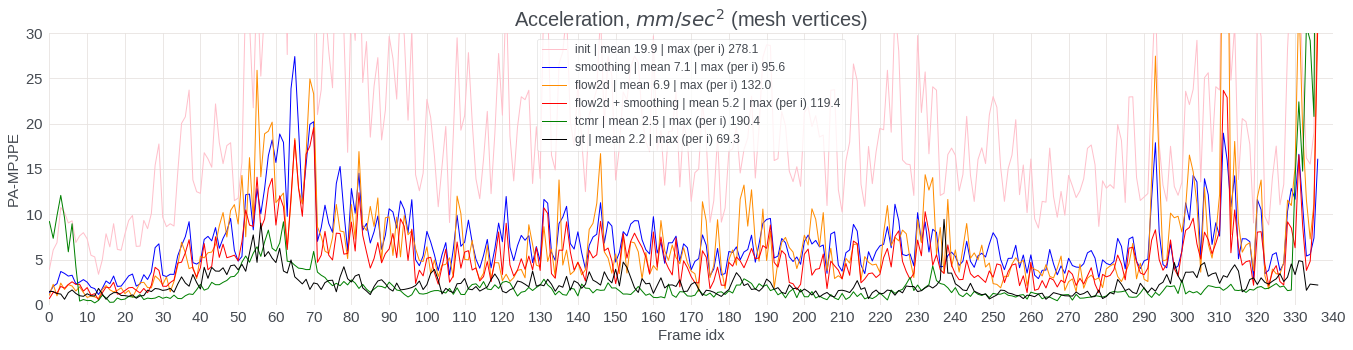

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(23, 5))

for name in ["init", "smoothing", "flow2d", "flow2d + smoothing", "tcmr", "gt"]:
    accel = d_accel_verts[name]
    accel_normed = norm_accel(accel)
    ax.plot(
        accel_normed.mean(dim=1),
        label=f"{name} | mean {float(accel_normed.mean()):.1f} | max (per i) {float(accel_normed.max()):.1f}",
        c=colors[name],
        linewidth=1,
    )

ax.legend(fontsize=12, loc="upper center")
max_x = 340
ax.set_xticks(range(0,max_x+10, 10))
ax.set_xlim((0, max_x))
ax.set_ylim((0, 30))
ax.set_xlabel("Frame idx")
ax.set_ylabel("PA-MPJPE")
ax.set_title(r"Acceleration, $mm/sec^2$ (mesh vertices)", fontsize=20)
fig.patch.set_facecolor("white")

In [16]:
d_accel_err_verts = {}
accel_gt = d_accel_verts["gt"]
for name, accel in d_accel_verts.items():
    if name == "gt":
        continue
    num_frames = accel.size(0)
    d_accel_err_verts[name] = accel_err(accel, accel_gt)

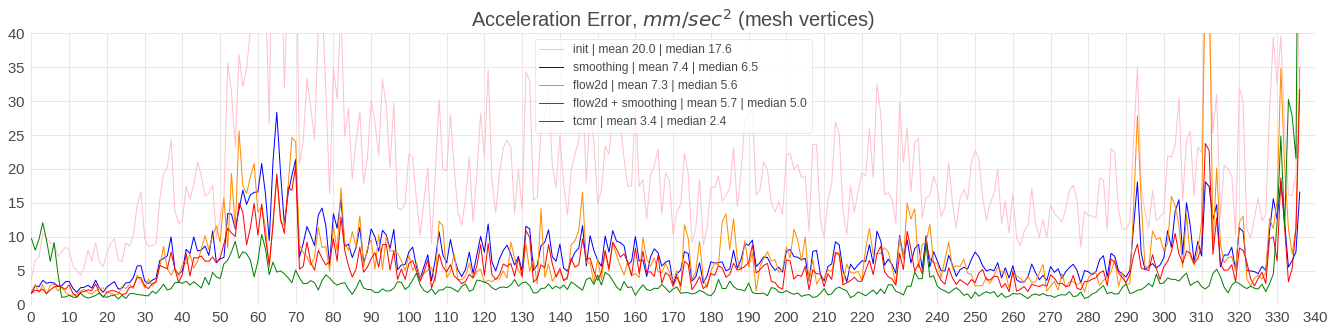

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(23, 5))

for name in ["init", "smoothing", "flow2d", "flow2d + smoothing", "tcmr"]:
    accel_err_ = d_accel_err_verts[name]
    ax.plot(
        accel_err_,
        label=f"{name} | mean {float(accel_err_.mean()):.1f} | median {float(accel_err_.median()):.1f}",
        c=colors[name],
        linewidth=1,
    )

ax.legend(fontsize=12, loc="upper center")
max_x = 340
ax.set_xticks(range(0,max_x+10, 10))
ax.set_xlim((0, max_x))
ax.set_ylim((0, 40))
ax.set_title(r"Acceleration Error, $mm/sec^2$ (mesh vertices)", fontsize=20)
fig.patch.set_facecolor("white")

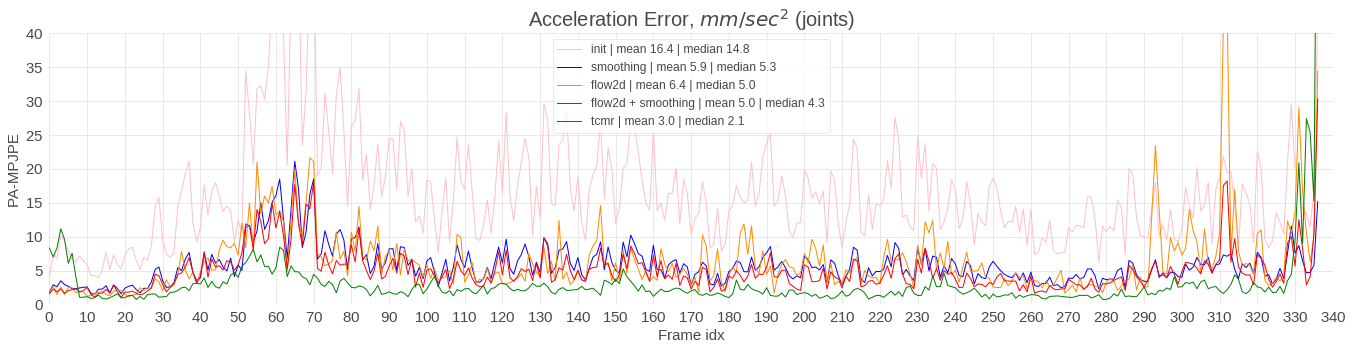

In [18]:
d_accel_err_j3d = {}
accel_gt = d_accel_j3d["gt"]
for name, accel in d_accel_j3d.items():
    if name == "gt":
        continue
    num_frames = accel.size(0)
    d_accel_err_j3d[name] = accel_err(accel, accel_gt)

fig, ax = plt.subplots(1, 1, figsize=(23, 5))

for name in ["init", "smoothing", "flow2d", "flow2d + smoothing", "tcmr"]:
    accel_err_ = d_accel_err_j3d[name]
    ax.plot(
        accel_err_,
        label=f"{name} | mean {float(accel_err_.mean()):.1f} | median {float(accel_err_.median()):.1f}",
        c=colors[name],
        linewidth=1,
    )

ax.legend(fontsize=12, loc="upper center")
max_x = 340
ax.set_xticks(range(0,max_x+10, 10))
ax.set_xlim((0, max_x))
ax.set_ylim((0, 40))
ax.set_xlabel("Frame idx")
ax.set_ylabel("PA-MPJPE")
ax.set_title(r"Acceleration Error, $mm/sec^2$ (joints)", fontsize=20)
fig.patch.set_facecolor("white")

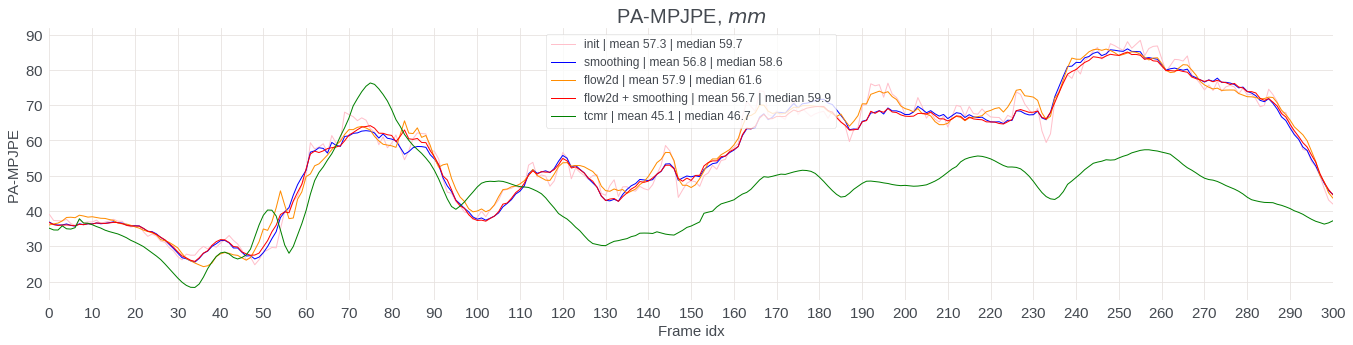

In [19]:
d_pa_mpjpe = {}
j3d_gt = d_j3d["gt"].clone()
for name, j3d in d_j3d.items():
    if name == "gt":
        continue
    d_pa_mpjpe[name] = pa_mpjpe_vs_gt(j3d, j3d_gt) * 1000

fig, ax = plt.subplots(1, 1, figsize=(23, 5))

for name in ["init", "smoothing", "flow2d", "flow2d + smoothing", "tcmr"]:
    pa_mpjpe_ = d_pa_mpjpe[name]
    ax.plot(
        pa_mpjpe_,
        label=f"{name} | mean {float(pa_mpjpe_.mean()):.1f} | median {float(pa_mpjpe_.median()):.1f}",
        c=colors[name],
        linewidth=1,
    )

ax.legend(fontsize=12, loc="upper center")
max_x = 300
ax.set_xticks(range(0, max_x + 10, 10))
ax.set_xlim((0, max_x))
ax.set_xlabel("Frame idx")
ax.set_ylabel("PA-MPJPE")
ax.set_title(r"PA-MPJPE, $mm$", fontsize=20)
fig.patch.set_facecolor("white")

# write videos

In [43]:
video_dir = "/tmp/videos_TCMR_20221010/"
os.makedirs(video_dir, exist_ok=True)

In [45]:
from src.utils.vis_utils import render_verts_only
from src.utils.video_utils import write_video

In [46]:
faces = smpl_model.faces.astype(int)

In [54]:
l, r = 100, 100  # orig size is 512 x 512
fps = 30
for name, verts_all in d_verts.items():
    print(name, verts_all.shape)
    frames_out = []
    for i in range(len(verts_all)):
        verts = verts_all[i].cpu().numpy()
        blend = render_verts_only(verts, faces, device)[:, l:-r]
        frames_out.append(blend)

    write_video(frames_out, f"{video_dir}verts_{name}.mp4", fps=fps)

gt torch.Size([339, 6890, 3])


/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/110b607930331a92/ar_sharing/body_tracking_3d/models/hmr/__bento_kernel_body_tracking__/bento_kernel_body_tracking#link-tree/pytorch3d/renderer/mesh/textures.py:324: PendingDeprecationWarning:

Textures class is deprecated,
        use TexturesUV, TexturesAtlas, TexturesVertex instead.
        Textures class will be removed in future releases.



Video is saved to '/tmp/videos_TCMR_20221010/verts_gt.mp4'
init torch.Size([339, 6890, 3])
Video is saved to '/tmp/videos_TCMR_20221010/verts_init.mp4'
tcmr torch.Size([339, 6890, 3])
Video is saved to '/tmp/videos_TCMR_20221010/verts_tcmr.mp4'
smoothing torch.Size([339, 6890, 3])
Video is saved to '/tmp/videos_TCMR_20221010/verts_smoothing.mp4'
flow2d torch.Size([339, 6890, 3])
Video is saved to '/tmp/videos_TCMR_20221010/verts_flow2d.mp4'
flow2d + smoothing torch.Size([339, 6890, 3])
Video is saved to '/tmp/videos_TCMR_20221010/verts_flow2d + smoothing.mp4'


In [22]:
from src.utils.video_utils import get_frames, write_video, write_video_gif

video_paths = [
    "/tmp/videos_TCMR_20221010/verts_init.mp4",
    "/tmp/videos_TCMR_20221010/verts_smoothing.mp4",
    "/tmp/videos_TCMR_20221010/verts_flow2d.mp4",
    "/tmp/videos_TCMR_20221010/verts_flow2d + smoothing.mp4",
    "/tmp/videos_TCMR_20221010/verts_tcmr.mp4",
    "/tmp/videos_TCMR_20221010/verts_gt.mp4",
]

vid_frames = []
for vid_path in video_paths:
    frame_list, _ = get_frames(pathmgr.get_local_path(vid_path), scale=0.5)
    vid_frames.append(frame_list)

In [23]:
video_dir = "/tmp/videos_final_pres/"
os.makedirs(video_dir, exist_ok=True)
num_frames = len(frame_list)

out_frames = []
for frame_idx in range(num_frames):
    out_frame = np.concatenate(
        (
            vid_frames[0][frame_idx],
            vid_frames[1][frame_idx],
            vid_frames[2][frame_idx],
            vid_frames[3][frame_idx],
            vid_frames[4][frame_idx],
            vid_frames[5][frame_idx],
        ),
        axis=1,
    )
    out_frames.append(out_frame)

write_video(out_frames, "/tmp/videos_final_pres/concat_final_pres.mp4", fps=30)
write_video_gif(out_frames, "/tmp/videos_final_pres/concat_final_pres.gif", fps=30)

Video is saved to '/tmp/videos_final_pres/concat_final_pres.mp4'
Video is saved to '/tmp/videos_final_pres/concat_final_pres.gif'


In [ ]:
# img = UNNORMALIZE(seqOpt.orig_seq["img"]).to(device)
# scale, trans = camera[:, 0], camera[:, 1:]
# verts_all_bbox = convert_norm_points_to_bbox(verts_all, scale, trans, img_size)

# l, r = 50, 50
# frames_out = []
# for i in tqdm(range(len(verts_all_bbox))):
#     verts = verts_all_bbox[i].cpu().numpy()
#     img = img_orig[i]
#     blend = render_mesh_onto_image(img, verts, faces, device)[:, l:-r]
#     frames_out.append(blend)

# write_video(frames_out, f"{video_dir}Ours_{name}.mp4", fps=fps)